# LAB 3 - Information Security

Members:
* Andrea Andreozzi - 2163406
* Riccardo Scalco - 2155352
* Sergio Cibecchini - 2155353
* Luca Ferrari - 2166294

In [1]:
import random
from collections import Counter
import matplotlib.pyplot as plt
import math
import itertools
import numpy as np

### Task 1

In [2]:
n_bits = 7

error_patterns = ['0' * n_bits] + [
    ''.join('1' if i == j else '0' for j in range(n_bits))
    for i in range(n_bits)
]

def apply_error(x, e):
    return ''.join(str(int(a) ^ int(b)) for a, b in zip(x, e))

def wiretap_channel(x):
    e_y = random.choice(error_patterns)
    e_z = random.choice(error_patterns)
    y = apply_error(x, e_y)
    z = apply_error(x, e_z)
    return y, z

def verify_channel(x, num_samples=100_000):
    freq_y = Counter()
    freq_z = Counter()
    freq_yz = Counter()
    for _ in range(num_samples):
        y, z = wiretap_channel(x)
        freq_y[y] += 1
        freq_z[z] += 1
        freq_yz[(y, z)] += 1
    return freq_y, freq_z, freq_yz

def plot_frequencies(counter, title):
    items = sorted(counter.items())
    labels, values = zip(*items)
    plt.figure(figsize=(12, 5))
    plt.bar(labels, values)
    plt.xticks(rotation=90)
    plt.title(title)
    plt.xlabel('Bit Pattern')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

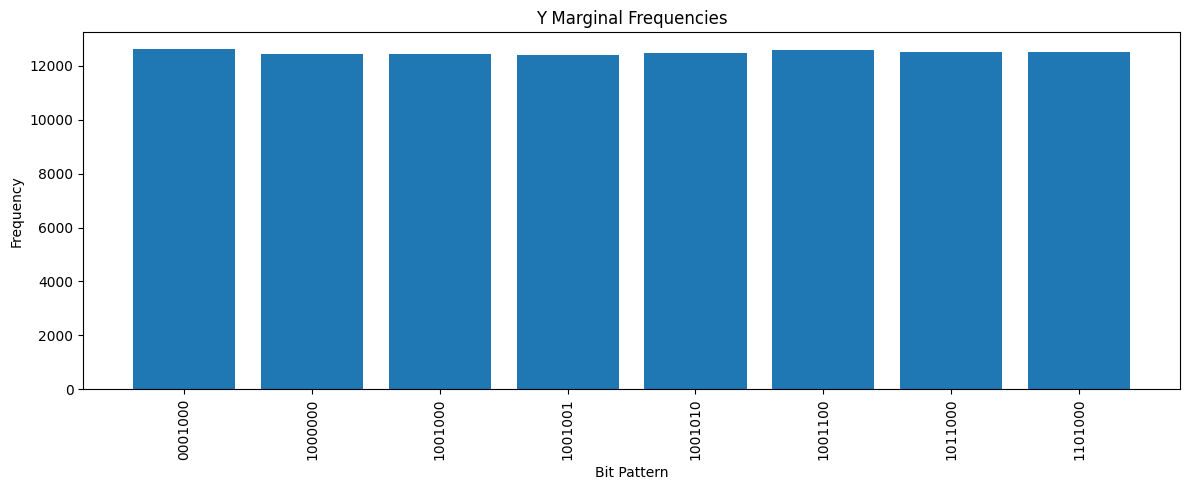

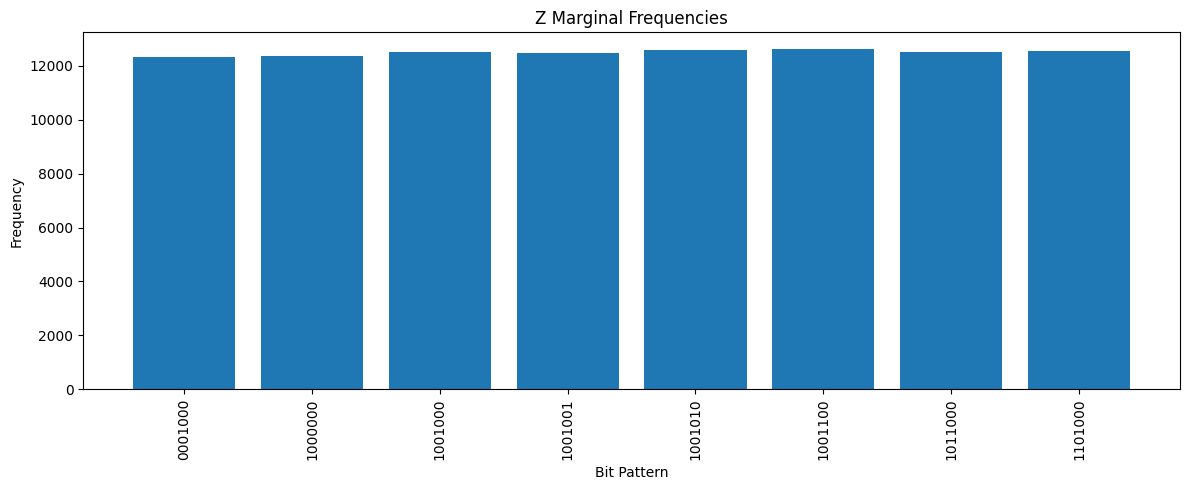

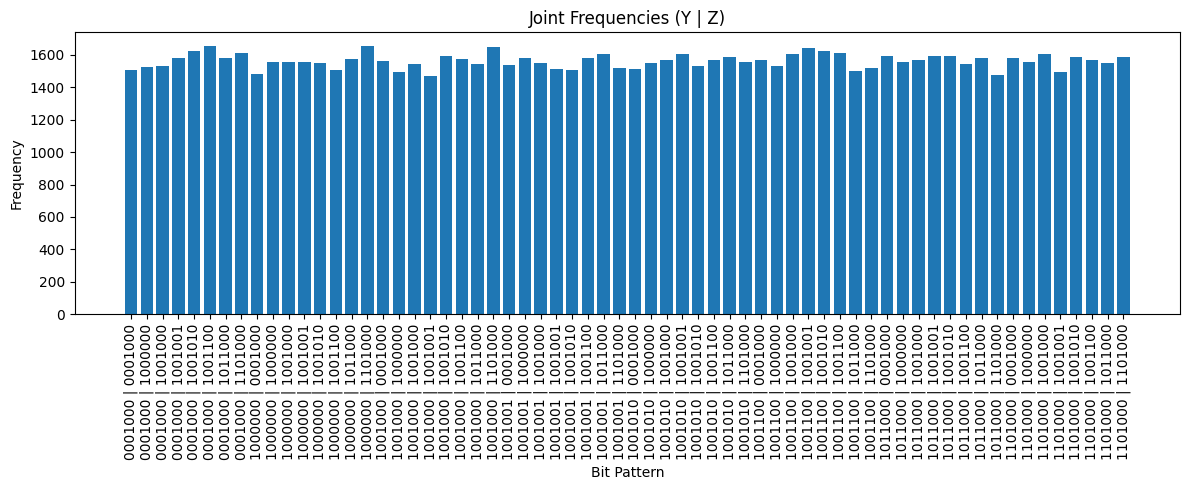

In [3]:
x = '1001000'
fy, fz, fyz = verify_channel(x)
plot_frequencies(fy, 'Y Marginal Frequencies')
plot_frequencies(fz, 'Z Marginal Frequencies')
fyz_str_keys = Counter({f'{k[0]} | {k[1]}': v for k, v in fyz.items()})
plot_frequencies(fyz_str_keys, 'Joint Frequencies (Y | Z)')

### Task 2 - Task 3

In [4]:

H = [
    [1, 0, 0, 0, 1, 1, 1],
    [0, 1, 0, 1, 0, 1, 1],
    [0, 0, 1, 1, 1, 0, 1],
]

col_to_syndrome = {
    i: ''.join(str(H[row][i]) for row in range(3))
    for i in range(n_bits)
}
syndrome_to_error = {
    ''.join('0' for _ in range(3)): '0' * n_bits,
    **{
        syn: ''.join('1' if idx == i else '0' for i in range(n_bits))
        for idx, syn in col_to_syndrome.items()
    }
}

def syndrome(x):
    return ''.join(
        str(sum(int(x[j]) * H[i][j] for j in range(n_bits)) % 2)
        for i in range(3)
    )

def error_from_syndrome(s):
    return syndrome_to_error.get(s, '0' * n_bits)

def correct_with_syndrome(received, sent_syndrome):
    recv_syn = syndrome(received)
    err_syn = ''.join(str(int(a) ^ int(b)) for a, b in zip(recv_syn, sent_syndrome))
    return apply_error(received, error_from_syndrome(err_syn))

def forward_reconciliation(x, trials=10000):
    fwd_ok = 0
    for _ in range(trials):
        y, z = wiretap_channel(x)
        sent_syn = syndrome(x)
        if correct_with_syndrome(z, sent_syn) == x:
            fwd_ok += 1
    return fwd_ok

def reverse_reconciliation(x, trials=10000):
    rev_ok = 0
    for _ in range(trials):
        y, z = wiretap_channel(x)
        sent_syn = syndrome(y)
        if correct_with_syndrome(z, sent_syn) == y:
            rev_ok += 1
    return rev_ok

In [5]:
x = '1001000'
fwd_success = forward_reconciliation(x)
rev_success = reverse_reconciliation(x)
print(f'Forward: E recovers x exactly in all trials: {fwd_success}/10000')
print(f'Reverse: E recovers y exactly in {rev_success}/10000 trials')

Forward: E recovers x exactly in all trials: 10000/10000
Reverse: E recovers y exactly in 3448/10000 trials


### Task 4 - Task 5

In [6]:
A = [
    [1,0,0,0,0,0,1],
    [0,1,0,0,1,1,0],
    [0,0,1,0,1,0,0],
    [0,0,0,1,1,0,0],
]

def det_priv_ampl(y):
    return ''.join(str(sum(int(y[j]) * A[i][j] for j in range(7)) % 2) for i in range(4))

def random_linear_hash(l):
    return [[random.randint(0,1) for _ in range(4)] for _ in range(l)]

def apply_hash(y_p, U):
    return ''.join(str(sum(int(y_p[j]) * U[i][j] for j in range(4)) % 2) for i in range(len(U)))

def test_det_ampl(trials=10000):
    f_global = Counter()
    f_cond = {}
    for _ in range(trials):
        x = ''.join(random.choice('01') for _ in range(7))
        y, _ = wiretap_channel(x)
        c = syndrome(x)
        y_p = det_priv_ampl(y)
        f_global[y_p] += 1
        f_cond.setdefault(c, Counter())[y_p] += 1
    total = sum(f_global.values())
    devs = []
    for counter in f_cond.values():
        tot = sum(counter.values())
        for y_p, cnt in counter.items():
            devs.append(abs(cnt/tot - f_global[y_p]/total))
    return f_global, max(devs)

def test_prob_ampl(trials=500_000):
    results = {}
    for l in (1, 2, 3):
        U = random_linear_hash(l) 
        f_global = Counter()
        f_c = {}  
        f_z = {}   

        for _ in range(trials):
            x = ''.join(random.choice('01') for _ in range(7))
            y, z = wiretap_channel(x)
            c = syndrome(x)
            y_p = det_priv_ampl(y) 
            k = apply_hash(y_p, U)
            f_global[k] += 1
            f_c.setdefault(c, Counter())[k] += 1
            f_z.setdefault(z, Counter())[k] += 1

        total = sum(f_global.values())

        dev_c = 0.0
        for c_key, counter_c in f_c.items():
            tot_c = sum(counter_c.values())
            for k_bitstring, cnt in counter_c.items():
                p_cond = cnt / tot_c
                p_marg = f_global[k_bitstring] / total
                dev_c = max(dev_c, abs(p_cond - p_marg))

        dev_z = 0.0
        for z_key, counter_z in f_z.items():
            tot_z = sum(counter_z.values())
            for k_bitstring, cnt in counter_z.items():
                p_cond = cnt / tot_z
                p_marg = f_global[k_bitstring] / total
                dev_z = max(dev_z, abs(p_cond - p_marg))

        results[l] = (dev_c, dev_z)

    return results

In [7]:
f_global, det_dev = test_det_ampl()
print('Deterministic y\' counts:', f_global)
print('Max deviation P(y\'|c) vs P(y\'):', det_dev)
prob_results = test_prob_ampl()
for l, (dev_c, dev_z) in prob_results.items():
    print(f'l={l}  max dev wrt c: {dev_c:.4f}, wrt z: {dev_z:.4f}')

Deterministic y' counts: Counter({'1001': 695, '1110': 661, '1111': 648, '0010': 646, '1010': 640, '0111': 631, '1101': 624, '0001': 620, '0011': 611, '0110': 610, '1011': 610, '1100': 610, '1000': 602, '0100': 600, '0000': 599, '0101': 593})
Max deviation P(y'|c) vs P(y'): 0.016600000000000004
l=1  max dev wrt c: 0.0032, wrt z: 0.1445
l=2  max dev wrt c: 0.0043, wrt z: 0.1117
l=3  max dev wrt c: 0.0031, wrt z: 0.1754


### Task 6

In [8]:
def bsc_channel(x, error_rate):
    return ''.join(str(int(a) ^ (random.random() < error_rate)) for a in x)

def wiretap_bsc(x, eps, delta):
    return bsc_channel(x, eps), bsc_channel(x, delta)

def bit_error_stats(length, eps, delta):
    orig = ''.join(random.choice('01') for _ in range(length))
    y, z = bsc_channel(orig, eps), bsc_channel(orig, delta)
    err_y = sum(o != r for o, r in zip(orig, y))
    err_z = sum(o != r for o, r in zip(orig, z))
    return err_y/length, err_z/length

def simulate_protocol(rounds, eps, delta):
    reliable = 0
    eavesdropped = 0
    for _ in range(rounds):
        x = ''.join(random.choice('01') for _ in range(7))
        y, z = wiretap_bsc(x, eps, delta)
        c = syndrome(x)
        x_hat = correct_with_syndrome(y, c)
        x_e = correct_with_syndrome(z, c)
        if x_hat == x:
            reliable += 1
        if x_e == x:
            eavesdropped += 1
    return reliable/rounds, eavesdropped/rounds

In [9]:
eps=0.1
delta=0.3
length=100000

In [10]:
ey, ez = bit_error_stats(length,eps, delta)
print(f'Legitimate bit error rate ≈ {ey:.3f}')
print(f'Eavesdropper bit error rate ≈ {ez:.3f}')
rel, eav = simulate_protocol(length,eps, delta)
print(f'Protocol reliability: {rel:.3f}')
print(f'Eavesdropper success: {eav:.3f}')

Legitimate bit error rate ≈ 0.099
Eavesdropper bit error rate ≈ 0.301
Protocol reliability: 0.849
Eavesdropper success: 0.330


### Task 7

In [11]:
eps_list = [round(e, 5) for e in np.linspace(0.05, 0.15, 10)]
delta = 0.3  
l_list = [1, 2, 3]
trials = 100_000  

In [12]:
def simulate_round(eps, delta, U):
    x = ''.join(random.choice('01') for _ in range(7))
    y, z = wiretap_bsc(x, eps, delta)
    c = syndrome(y)
    x_A = correct_with_syndrome(x, c)
    y_A = det_priv_ampl(x_A)
    y_B = det_priv_ampl(y)
    k_A = apply_hash(y_A, U)
    k_B = apply_hash(y_B, U)
    return k_A, k_B, z, c

def p_star(kA, kB, l):
    return (1 / (2 ** l)) if kA == kB else 0

def compute_metrics(eps, delta, l):
    U = random_linear_hash(l)
    joint = Counter()
    p_zc = Counter()
    marg_kA = Counter()
    marg_kB = Counter()

    for _ in range(trials):
        kA, kB, z, c = simulate_round(eps, delta, U)
        joint[(kA, kB, z, c)] += 1
        p_zc[(z, c)] += 1
        marg_kA[kA] += 1
        marg_kB[kB] += 1

    p_kA = {k: v / trials for k, v in marg_kA.items()}
    p_kB = {k: v / trials for k, v in marg_kB.items()}
    p_zc = {zc: v / trials for zc, v in p_zc.items()}

    mismatch = sum(v for (kA, kB, *_), v in joint.items() if kA != kB) / trials

    H_kA = -sum(p * math.log2(p) for p in p_kA.values() if p > 0)
    H_kB = -sum(p * math.log2(p) for p in p_kB.values() if p > 0)

    joint_kA_zc = Counter()
    joint_kB_zc = Counter()
    for (kA, kB, z, c), v in joint.items():
        joint_kA_zc[(kA, z, c)] += v
        joint_kB_zc[(kB, z, c)] += v

    I_kA_zc = sum((v / trials) * math.log2((v / trials) / (p_kA[kA] * p_zc[(z, c)]))
                   for (kA, z, c), v in joint_kA_zc.items())
    I_kB_zc = sum((v / trials) * math.log2((v / trials) / (p_kB[kB] * p_zc[(z, c)]))
                   for (kB, z, c), v in joint_kB_zc.items())

    dV = 0.0
    for (kA, kB, z, c), v in joint.items():
        p_joint = v / trials
        p_model = p_star(kA, kB, l) * p_zc[(z, c)]
        dV += abs(p_joint - p_model)
    dV *= 0.5

    return mismatch, H_kA, H_kB, I_kA_zc, I_kB_zc, dV

In [18]:
def plot_task7(eps_list, l_list, delta):
        
    results = {
        (eps, l): compute_metrics(eps, delta, l)
        for eps, l in itertools.product(eps_list, l_list)
    }

    metrics = [
        ('Mismatch P[kA!=kB]', 0),
        ('l - H(kA)', lambda r, l: l - r[1]),
        ('l - H(kB)', lambda r, l: l - r[2]),
        ('I(kA;z,c)', 3),
        ('I(kB;z,c)', 4),
        ('d_V', 5),
    ]

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    for ax, (title, idx_or_fn) in zip(axes.flatten(), metrics):
        for l in l_list:
            xs = eps_list
            ys = []
            for eps in eps_list:
                r = results[(eps, l)]
                if callable(idx_or_fn):
                    ys.append(idx_or_fn(r, l))
                else:
                    ys.append(r[idx_or_fn])
            ax.plot(xs, ys, marker='o', label=f'l={l}')
        ax.set_title(title)
        ax.set_xlabel('ε (δ=0.3)')
        ax.legend()

    plt.tight_layout()
    plt.show()

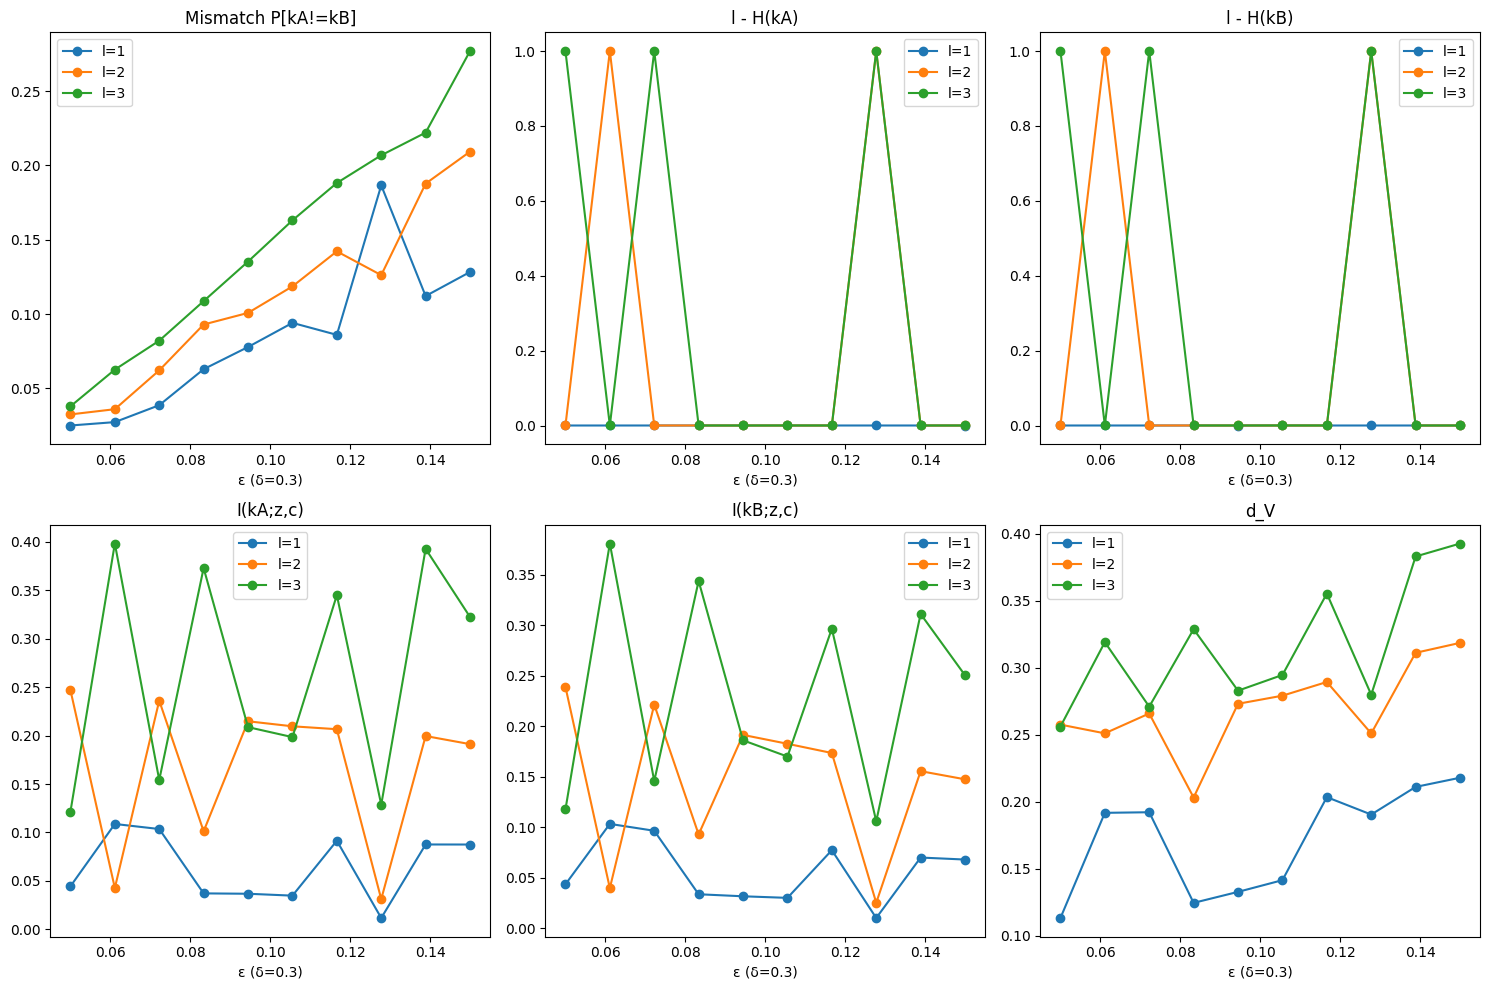

In [19]:
plot_task7(eps_list, l_list, delta)